# Финальный проект в домене Телеком



Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).


Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Задача:** создать модель для предсказания оттока клиентов. Метрика на тестовой выборке AUC-ROC=>0.85


**План работы:**
- загрузить данные, изучить их
- подготовить данные для обучения модели
- обучить несколько моделей одна из бустинга, другая из деревянных
- подготовить вывод-отчет для заказчика

**Задачи:**
- подгрузить библиотеки
- проверить наличие дубликатов, пропусков, изменить тип данных при необходимости, изучить данные (распределение, корреляцию, построить графики)
- подготовить базу для обучения моделей, разбить на обучающую 75% и тестовую 25% выборки
- выбрать необходимые признаки, закодировать их, избавить от дисбаланса при необходимости
- подобрать лучшие параметры для моделей при обучении и оценить их качество метрикой AUC-ROC
- подготовить вывод-отчет для заказчика

## Изучение данных.

Загрузим необходимые библиотеки и ознакомимся с данными.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


RANDOM_STATE = 220523

In [3]:
contract = pd.read_csv("/datasets/contract_new.csv", index_col= 'customerID', parse_dates = ['BeginDate', 'EndDate'])
internet = pd.read_csv("/datasets/internet_new.csv", index_col= 'customerID')
personal = pd.read_csv("/datasets/personal_new.csv", index_col= 'customerID')
phone = pd.read_csv("/datasets/phone_new.csv", index_col= 'customerID')

'BeginDate' и 'EndDate' откроем сразу с тиипом данных datetime, customerID используем как индекс.

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [5]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Пропусков нет, почти все типы данных "объект". EndDate не определился как datetime, проверим этот столбец. TotalCharges изменим тип данных. <br>
Названия столбцов менять не будем.

In [6]:
# уникальные значения по колонке даты окончания обслуживания.
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

В основном контракты продолжают действовать. Изменим тип данных в колонке на datetime. И используем аргумент errors='coerce', который при ошибке с переводом строки в дату оставит пустую строку, тем самым показав, что договор не закрыт.

In [7]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

In [8]:
# проверим уникальные значения по типу контракта 
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [9]:
contract['Type'] = contract['Type'].astype('str')

In [10]:
# проверим уникальные значения по колонке об электронном счете
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [11]:
#уникальные значения по колонке способ оплаты
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Колонку с суммарной оплатой переведем в численный тип данных.

In [12]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


При переводе появились пропуски. Заполним образовавшиеся пропуски в колонке нулевыми значениями.

In [14]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


In [16]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50


In [17]:
print('Количество клиентов с закрытым контактом, будущий таргет:', round(contract['EndDate'].count()/contract.shape[0]*100, 2), '%')

Количество клиентов с закрытым контактом, будущий таргет: 15.63 %


In [18]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


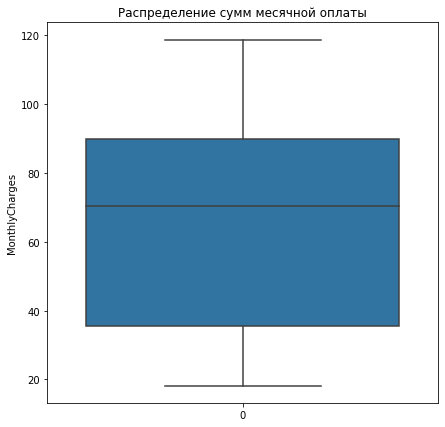

In [19]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=contract['MonthlyCharges'])
plt.title('Распределение сумм месячной оплаты')
plt.ylabel('MonthlyCharges')
plt.show()

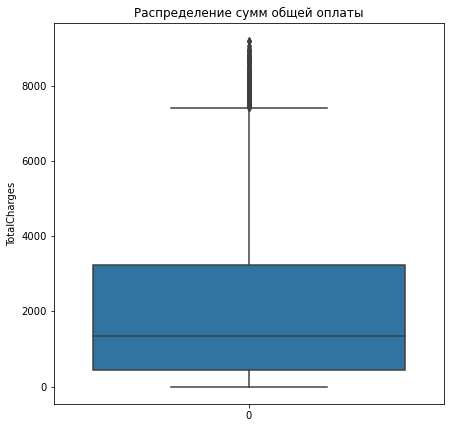

In [20]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=contract['TotalCharges'])
plt.title('Распределение сумм общей оплаты')
plt.ylabel('TotalCharges')
plt.show()

Поскольку единица измерения суммы  оплаты (валюта) не указана, то обозначим как условную единицу (у.е.) 

In [21]:
print('Итоговая сумма поступлений у.е. от клиентов которые заплатили больше 3236 у.е. - 25% самых доходных клиентов:', round(contract[contract['TotalCharges']>3236]['TotalCharges'].sum(),2))
print('Процент прибыли от 25% самых прибыльных клиентов ко всем:', round(contract[contract['TotalCharges']>3236]['TotalCharges'].sum()/contract['TotalCharges'].sum()*100, 2), '%')

Итоговая сумма поступлений у.е. от клиентов которые заплатили больше 3236 у.е. - 25% самых доходных клиентов: 9301428.36
Процент прибыли от 25% самых прибыльных клиентов ко всем: 62.43 %


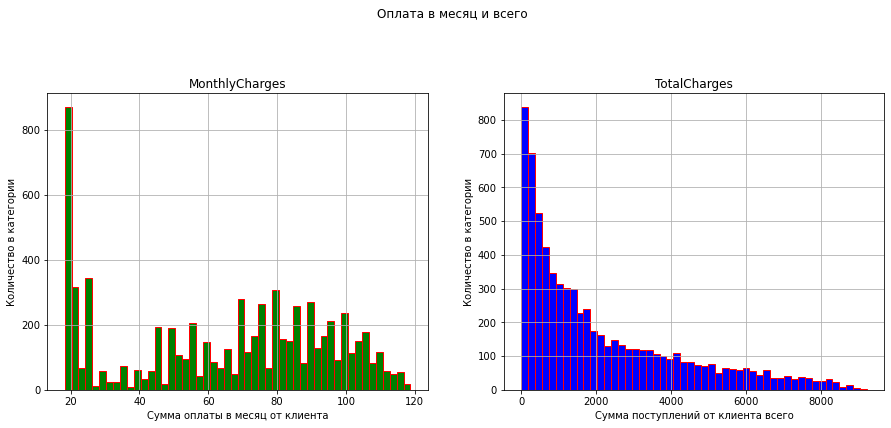

In [22]:
plt.figure(figsize=[15, 12])

plt.suptitle('Оплата в месяц и всего')


# Plot 1
plt.subplot(2, 2, 1)
plt.hist(contract['MonthlyCharges'], bins=50, color='green', ec='red')
plt.title('MonthlyCharges')
plt.grid (True)
plt.ylabel('Количество в категории')
plt.xlabel('Сумма оплаты в месяц от клиента')

# Plot 2
plt.subplot(2, 2, 2)
plt.hist(contract['TotalCharges'], bins=50, color='blue', ec='red')
plt.title('TotalCharges')
plt.grid (True)
plt.ylabel('Количество в категории')
plt.xlabel('Сумма поступлений от клиента всего')

plt.show()

In [23]:
print('Количество клиентов с оплатой ниже 21 денежной единицы в месяц:', contract[contract['MonthlyCharges']<21]['MonthlyCharges'].count())
print('Процент клиентов с оплатой ниже 21 денежной единицы:', round(contract[contract['MonthlyCharges']<21]['MonthlyCharges'].count()/contract['MonthlyCharges'].count()*100, 2), '%')

Количество клиентов с оплатой ниже 21 денежной единицы в месяц: 1159
Процент клиентов с оплатой ниже 21 денежной единицы: 16.46 %


In [24]:
print('Количество клиентов с оплатой ниже 42 денежной единицы за все время:', contract[contract['TotalCharges']<42]['TotalCharges'].count())
print('Процент клиентов с оплатой ниже 42 денежной единицы за все время:', round(contract[contract['TotalCharges']<42]['TotalCharges'].count()/contract['TotalCharges'].count()*100, 2), '%')

Количество клиентов с оплатой ниже 42 денежной единицы за все время: 180
Процент клиентов с оплатой ниже 42 денежной единицы за все время: 2.56 %


Имеем много контрактов с минимальной месячной оплатой.

In [25]:
contract.groupby('Type').count()

,BeginDate,EndDate,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
Type,,,,,,
Month-to-month,3875,407,3875,3875,3875,3875
One year,1473,313,1473,1473,1473,1473
Two year,1695,381,1695,1695,1695,1695


In [26]:
print('Процент клиентов с оплатой ежемесячной:', 
      round(contract[contract['Type']== 'Month-to-month']['Type'].count()/contract['Type'].count()*100, 2),'%')

print('Процент клиентов с оплатой ежегодно:', 
      round(contract[contract['Type']== 'One year']['Type'].count()/contract['Type'].count()*100, 2),'%')

print('Процент клиентов с оплатой кажые 2 года:', 
      round(contract[contract['Type']== 'Two year']['Type'].count()/contract['Type'].count()*100, 2),'%')

Процент клиентов с оплатой ежемесячной: 55.02 %
Процент клиентов с оплатой ежегодно: 20.91 %
Процент клиентов с оплатой кажые 2 года: 24.07 %


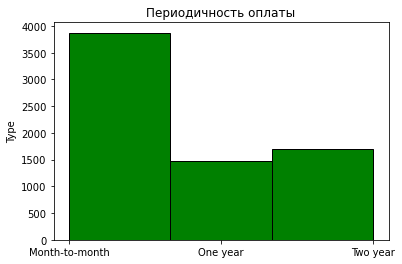

In [27]:
plt.hist(contract['Type'], color = 'green', edgecolor = 'black', bins = 3)
plt.title('Периодичность оплаты')
plt.ylabel('Type')

plt.show()

In [28]:
contract.groupby('PaperlessBilling').count()

,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges
PaperlessBilling,,,,,,
No,2872,380,2872,2872,2872,2872
Yes,4171,721,4171,4171,4171,4171


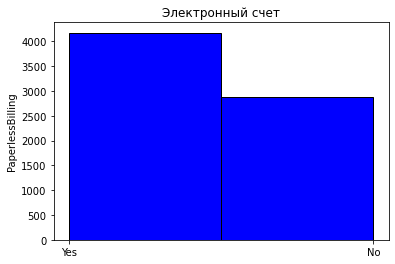

In [29]:
plt.hist(contract['PaperlessBilling'], color = 'blue', edgecolor = 'black', bins = 2)
plt.title('Электронный счет')
plt.ylabel('PaperlessBilling')
plt.show()


In [30]:
print('Процент клиентов желающих получить электронный счет:', round(contract[contract['PaperlessBilling']== 'Yes']['PaperlessBilling'].count()/contract['PaperlessBilling'].count()*100, 2),'%')

Процент клиентов желающих получить электронный счет: 59.22 %


Поменял типы данных в колонке с датой начала и окончания действия контракта. Поменял тип данных в колонках с денежными поступлениями в месяц и итогово.

16.46 % клиентов имеют месячную оплату ниже 21 у.е.

59.22 % клиентов желают получить электронный счет.

Преобладающее количество клиентов 55.02 % с оплатой помесячно.

25% самых прибыльных клиента делают 62.43 % выручки.

В данных имеем 15.63 % клиентов с закрытым контрактом. Мы видим что имеется дисбаланс классов, перекос в большей степени в сторону "клиент остается". От дисбаланса избавимся после объединения таблиц, при обучении моделей. Будущий таргет для обучения.



Рассмотрим файл internet

In [31]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [32]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


Посмотрим какие варианты значений есть в колонках.

In [33]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [34]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [35]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [36]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [37]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [38]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

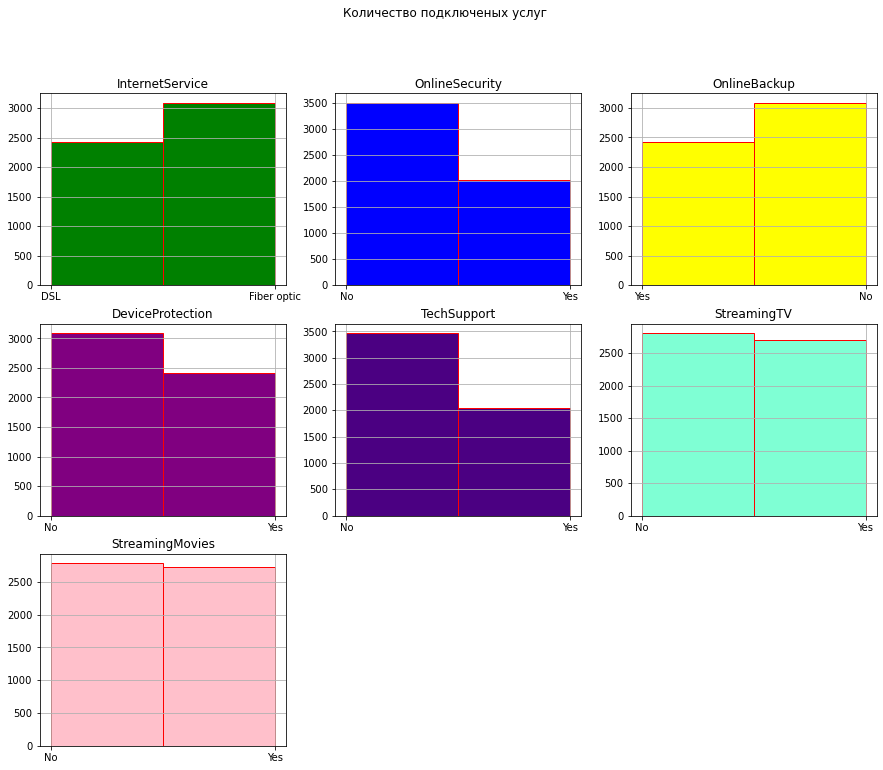

In [40]:
plt.figure(figsize=[15, 12])

plt.suptitle('Количество подключеных услуг')


# Plot 1
plt.subplot(3, 3, 1)
plt.hist(internet['InternetService'], bins=2, color='green', ec='red')
plt.title('InternetService')
plt.grid (True)

# Plot 2
plt.subplot(3, 3, 2)
plt.hist(internet['OnlineSecurity'], bins=2, color='blue', ec='red')
plt.title('OnlineSecurity')
plt.grid (True)

# Plot 3
plt.subplot(3, 3, 3)
plt.hist(internet['OnlineBackup'], color='yellow', bins=2, ec='red')
plt.title('OnlineBackup')
plt.grid (True)

# Plot 4
plt.subplot(3, 3, 4)
plt.hist(internet['DeviceProtection'], color='purple', bins=2, ec='red')
plt.title('DeviceProtection')
plt.grid (True)

# Plot 5
plt.subplot(3, 3, 5)
plt.hist(internet['TechSupport'], color='Indigo', bins=2, ec='red')
plt.title('TechSupport')
plt.grid (True)


# Plot 6
plt.subplot(3, 3, 6)
plt.hist(internet['StreamingTV'], color='Aquamarine', bins=2, ec='red')
plt.title('StreamingTV')
plt.grid (True)


# Plot 7
plt.subplot(3, 3, 7)
plt.hist(internet['StreamingMovies'], color='pink', bins=2, ec='red')
plt.title('StreamingMovies')
plt.grid (True)


plt.show()

В файле internet типы данных менять не будем. Потом будем использовать для кодирования признаков так как есть.

Рассмотрим файл personal

In [41]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [42]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [43]:
# пол
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [44]:
# пенсинер
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [45]:
# наличие партнера
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [46]:
# Иждивенцы
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [47]:
personal.groupby('SeniorCitizen').count()

,gender,Partner,Dependents
SeniorCitizen,,,
0,5901,5901,5901
1,1142,1142,1142


Пенсионеров 1142. 

Во  всех колонках по 2 варианта классификации.

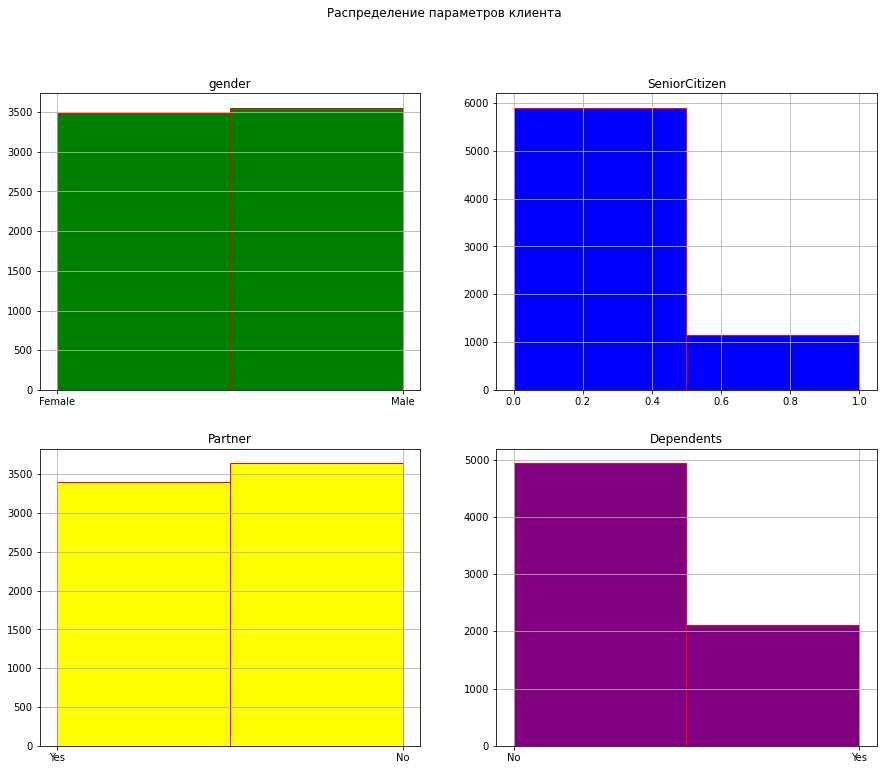

In [48]:
plt.figure(figsize=[15, 12])

plt.suptitle('Распределение параметров клиента')


# Plot 1
plt.subplot(2, 2, 1)
plt.hist(personal['gender'], bins=2, color='green', ec='red')
plt.title('gender')
plt.grid (True)

# Plot 2
plt.subplot(2, 2, 2)
plt.hist(personal['SeniorCitizen'], bins=2, color='blue', ec='red')
plt.title('SeniorCitizen')
plt.grid (True)

# Plot 3
plt.subplot(2, 2, 3)
plt.hist(personal['Partner'], color='yellow', bins=2, ec='red')
plt.title('Partner')
plt.grid (True)

# Plot 4
plt.subplot(2, 2, 4)
plt.hist(personal['Dependents'], color='purple', bins=2, ec='red')
plt.title('Dependents')
plt.grid (True)

plt.show()

Рассмотрим файл phone

In [49]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [50]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [51]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

In [52]:
phone.groupby('MultipleLines').count()

""
MultipleLines
No
Yes


Text(0.5, 1.0, 'MultipleLines')

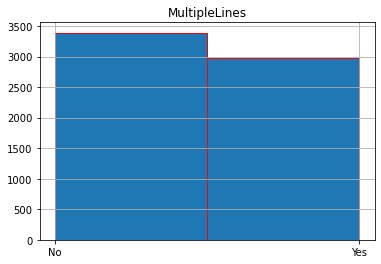

In [53]:
plt.hist(phone['MultipleLines'], bins=2, ec='red')
plt.grid(True)
plt.title('MultipleLines')

**Вывод:** пропусков в данных пока нет, дубликатов нет. Таблицы в дальнейшем объединим по customerID. 

## Подготовка данных, объединение таблиц и анализ.

Объединим таблицы по customerID

In [54]:
data = contract.merge(internet, on='customerID', how='outer')

In [55]:
data = data.merge(personal, on='customerID', how='outer')

In [56]:
data = data.merge(phone, on='customerID', how='outer')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   5517 non-null   object        
 8   OnlineSecurity    5517 non-null   object        
 9   OnlineBackup      5517 non-null   object        
 10  DeviceProtection  5517 non-null   object        
 11  TechSupport       5517 non-null   object        
 12  StreamingTV       5517 non-null   object        
 13  StreamingMovies   5517 non-null   object        
 14  gender        

In [58]:
data.head()


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [59]:
data.isnull().sum()

BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Объединил таблицы, появились пропуски. Все значения customerID уникальны в каждой строке. Мы видим взаимосвязь образовавшихся пропусков. Пропуски появились в местах где в базе internet не нашлось соответствующего id клиента из базы contract. Посему можем сделать вывод что услугами он не пользуется, а значит в местах этих пропусков можно проставить значени No. 


In [60]:
data['InternetService'] = data['InternetService'].fillna('No')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')

Добавим колонку с количеством дней обслуживания, а колонки с датой начала и конца обслуживания удалим, чтобы не было чрезмерного количества признаков при кодировании признаков с типом данных datetime.

In [61]:
data['Days'] = (pd.to_datetime(data['EndDate'].fillna('2020-02-01')) - data['BeginDate']).dt.days

Добавим таргет ушел клиент или действующий. Определим по наличию пустых ячеек в колонке дата выхода.

In [62]:
data['EndDate'] = data['EndDate'].fillna('No')

data['Exed'] = [0 if x==True else 1 for x in data['EndDate'] == 'No' ]

In [63]:
data['Exed'].value_counts()

0    5942
1    1101
Name: Exed, dtype: int64

0 соответствует значению - клиент действующий, 1 - покинул.

In [65]:
data = data.drop(['BeginDate', 'EndDate'], axis=1)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  gender            7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  Partner           7043 non-null   object 
 15  Dependents        7043 non-null   object 
 16  MultipleLines     7043 non-null 

In [67]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Days,Exed
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,31,0
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,153,0


In [68]:
data.duplicated().sum()

4

Появилось 4 дубликата, проверим их.

In [69]:
data[data.duplicated(keep=False)]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Days,Exed
customerID,,,,,,,,,,,,,,,,,,,
4376-KFVRS,Two year,Yes,Credit card (automatic),114.05,8211.60,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,2191,0
2866-IKBTM,Month-to-month,No,Mailed check,19.55,19.55,No,No,No,No,No,No,No,Female,0,No,No,No,31,0
4312-KFRXN,Two year,No,Mailed check,25.40,1828.80,No,No,No,No,No,No,No,Male,0,Yes,No,Yes,2191,0
8605-ITULD,Month-to-month,No,Mailed check,19.55,19.55,No,No,No,No,No,No,No,Female,0,No,No,No,31,0
0673-IGUQO,Month-to-month,No,Mailed check,20.45,20.45,No,No,No,No,No,No,No,Male,0,No,No,No,31,0
2668-TZSPS,Month-to-month,No,Mailed check,20.45,20.45,No,No,No,No,No,No,No,Male,0,No,No,No,31,0
3892-NXAZG,Two year,Yes,Credit card (automatic),114.05,8211.60,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,2191,0
8774-GSBUN,Two year,No,Mailed check,25.40,1828.80,No,No,No,No,No,No,No,Male,0,Yes,No,Yes,2191,0


In [ ]:
ункция duplicated() при оценке дубликатов не учитывает значение индекса. Индексы - customerID разные, а признаки у клиентов одинаковые. В таком случае удалять дубликаты не будем т.к. они не дубликаты)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  gender            7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  Partner           7043 non-null   object 
 15  Dependents        7043 non-null   object 
 16  MultipleLines     7043 non-null 

Используя библиотеку phik построим матрицу корреляции признаков.

In [72]:
corr = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Days'])

display(corr)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Days,Exed
Type,1.000000,0.106860,0.277462,0.388444,0.470860,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.000000,0.086231,0.179736,0.147680,0.065498,0.634155,0.094015
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.000000,0.242133,0.013218,0.172593,0.252972,0.026799,0.083398
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.000000,0.292725,0.243008,0.224903,0.339313,0.350964,0.214832
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.008175,0.304985,0.203545,0.184366,0.675883,0.387727,0.226280
TotalCharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.000000,0.135650,0.381958,0.084247,0.573191,0.848337,0.302890
InternetService,0.505187,0.231438,0.323886,0.919002,0.490081,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.000000,0.160702,0.000000,0.108463,0.225383,0.060845,0.056621
OnlineSecurity,0.152145,0.000000,0.262911,0.551621,0.522090,0.241421,1.000000,0.430425,0.418474,0.528391,0.272186,0.289097,0.018397,0.057028,0.221673,0.124945,0.151886,0.395693,0.132594
OnlineBackup,0.098884,0.196443,0.282475,0.629541,0.622445,0.233602,0.430425,1.000000,0.458211,0.445130,0.428007,0.417170,0.009882,0.102065,0.219223,0.031533,0.311403,0.414982,0.229482
DeviceProtection,0.137610,0.160796,0.306866,0.667481,0.640977,0.232916,0.418474,0.458211,1.000000,0.499267,0.575536,0.589888,0.000000,0.090686,0.238079,0.010416,0.309757,0.426931,0.218380
TechSupport,0.179999,0.055929,0.272101,0.576525,0.550065,0.239663,0.528391,0.445130,0.499267,1.000000,0.422242,0.424078,0.000000,0.092565,0.185993,0.096912,0.155739,0.404795,0.103652


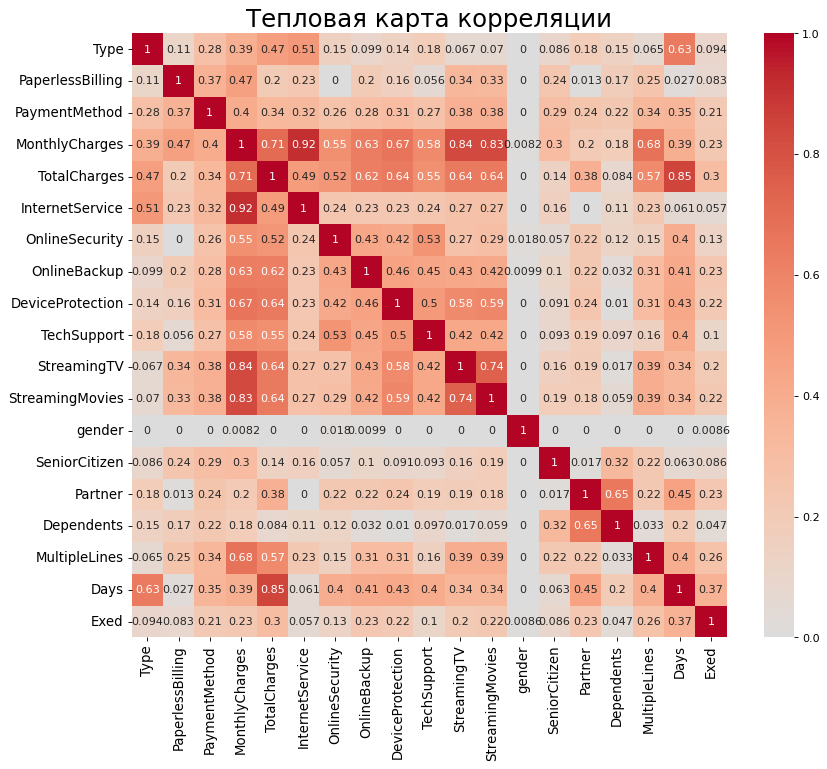

In [73]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm', center=0, annot=True
            )


plt.title('Тепловая карта корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Т.к. на тепловой карте корреляции мы видим, что пол не влияет на данные, просто удалим столбец для упрощения счета моделей. Признак MonthlyCharges также удалим т.к. он сильно коррелирует с другими признаками. Удаление сделаем позже, перед разбивкой на таргет и признаки.

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  gender            7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  Partner           7043 non-null   object 
 15  Dependents        7043 non-null   object 
 16  MultipleLines     7043 non-null 

In [75]:
data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'Days', 'Exed'],
      dtype='object')

In [76]:
cat_data = data[['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']]

Построим теперь график распределения таргета по признакам в полной таблице. В отдельности для категориальных признаков и численных.

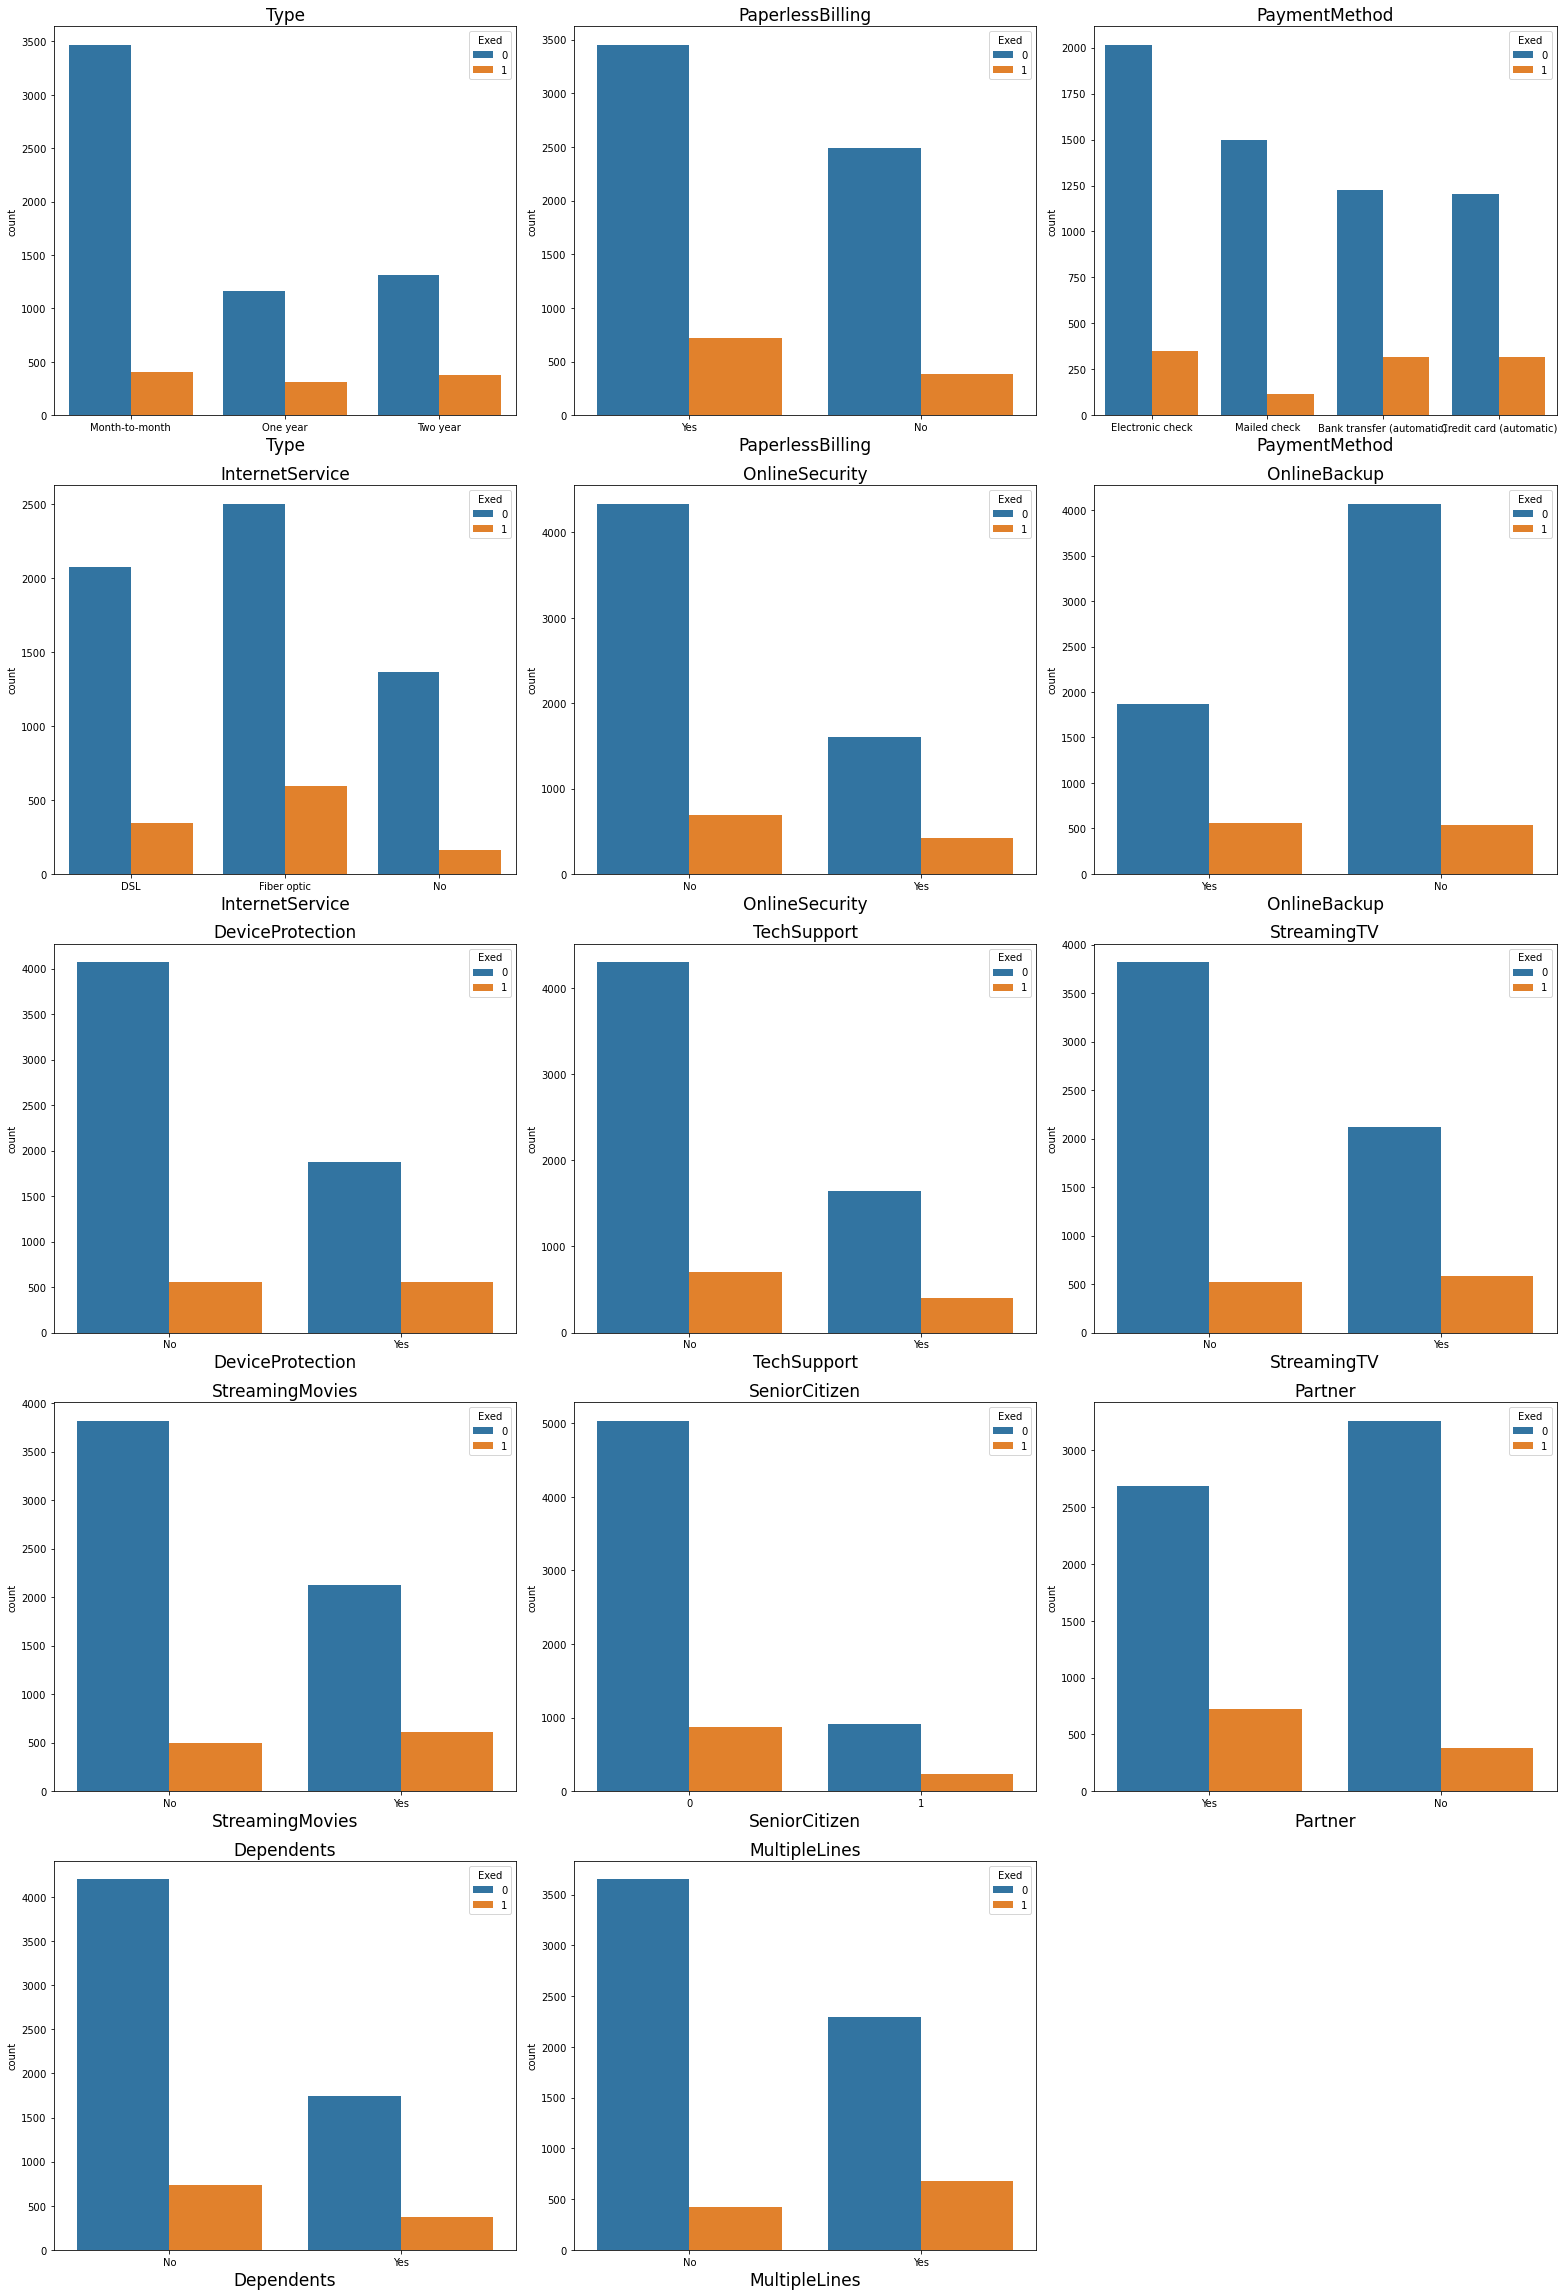

In [77]:
a = 5  # количество строк
b = 3  # количество колонок
c = 1  # номер графика

fig = plt.figure(figsize = (22,32))

for i in cat_data:
    plt.subplot(a, b, c)
    plt.title(i, size = 17)
    plt.xlabel(i, size = 17)
    sns.countplot(data = data, x = i, hue='Exed')
    c = c + 1

plt.tight_layout()
plt.show()

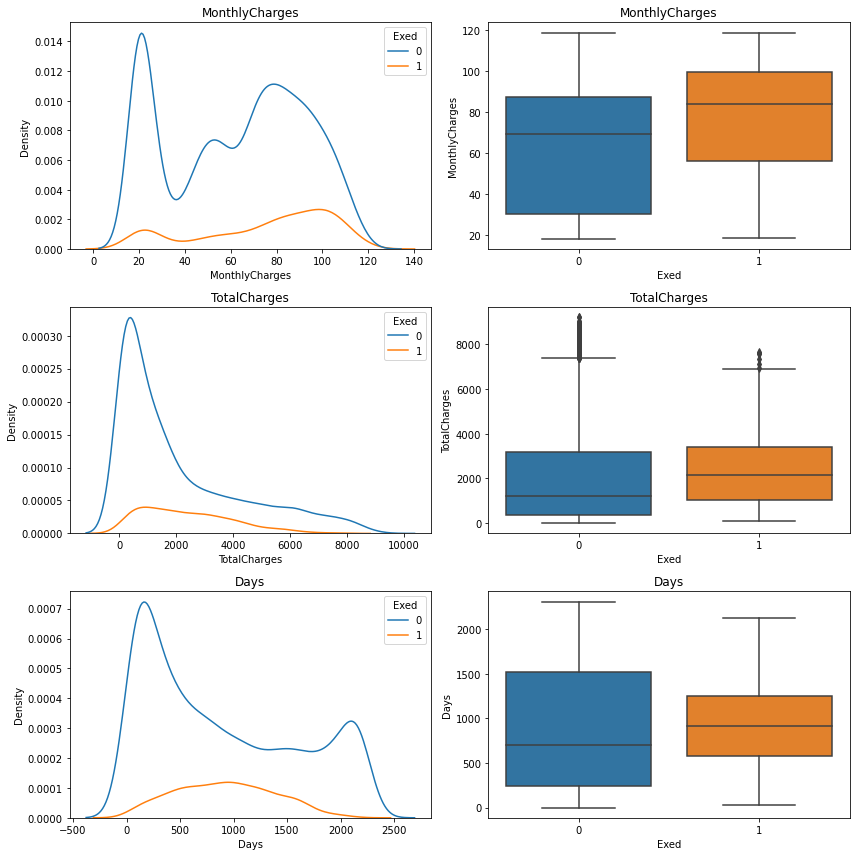

In [78]:
num_data = data[['MonthlyCharges', 'TotalCharges', 'Days']]

a = 3  # количество строк
b = 2  # количество колонок
c = 1  # номер графика

fig = plt.figure(figsize = (12,12))


for i in num_data:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.kdeplot(data = data, x = i, hue ='Exed')
    c = c + 1

    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.boxplot(data = data, y = i, x = 'Exed')
    c = c + 1


plt.tight_layout()
plt.show()

По признаку MonthlyCharges мы видим, что большее количество клиентов в находяся в районе оплаты 20 у.е., они же и остаются. Уходят те кто платит больше остальных помесячно. Наблюдается как раз пороговые значения по оплате для большинства клиентов в месяц. Вторая группа клиентов находится в районе 80 у.е. по оплате, как только сумма оплаты достигает 80-100 у.е. клиент начинает уходить. Видимо далее выходит так что клиент пытается уйти, ему предлагают значительную скидку, по итогу клиент остается, но дохода от него сильно меньше. Количество таких клиентов становится все больше. Больше 120 у.е. никто не платит.


Уходят в основном те кто заплатил за все время обслуживания до 2000, эта же и самая многочисленная группа клиентов. Чем больше дохода за все время тем меньше уходят. Много платят обычно юр лица, обеспеченные VIP клиенты, и те кто долго обслуживается.

В подтверждение гипотезы что чем долше клиент обслуживается тем менее склонен к уходу мы видим на графике количество дней обслуживания. Если клиент обслуживается более 2000 дней то расторжение контракта сводится к минимуму, эта же группа на втором месте по многочисленности, на первом 250-1500 дней.


Меньший отток среди пенсионеров и тех людей кто получают бумажные чеки.

**Вывод:** 4 базы данных были объединены, заполнил пропуски, поменял тип данных, провел анализ.

## Разбивка на выборки, кодирование.

In [79]:
data = data.drop(['gender', 'MonthlyCharges', 'TotalCharges'], axis=1)

Выделим признаки и таргет, разобьем датафрейм на обучающую и тестовую выборки и закодируем признаки поотдельности чтобы не было "подглядывания".

In [80]:
data

,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,Days,Exed
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,DSL,No,Yes,No,No,No,No,0,Yes,No,No,31,0
5575-GNVDE,One year,No,Mailed check,DSL,Yes,No,Yes,No,No,No,0,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,DSL,Yes,Yes,No,No,No,No,0,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),DSL,Yes,No,Yes,Yes,No,No,0,No,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,Fiber optic,No,No,No,No,No,No,0,No,No,No,153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,DSL,Yes,No,Yes,Yes,Yes,Yes,0,Yes,Yes,Yes,730,0
2234-XADUH,One year,Yes,Credit card (automatic),Fiber optic,No,Yes,Yes,No,Yes,Yes,0,Yes,Yes,Yes,2191,0
4801-JZAZL,Month-to-month,Yes,Electronic check,DSL,Yes,No,No,No,No,No,0,Yes,Yes,No,337,0


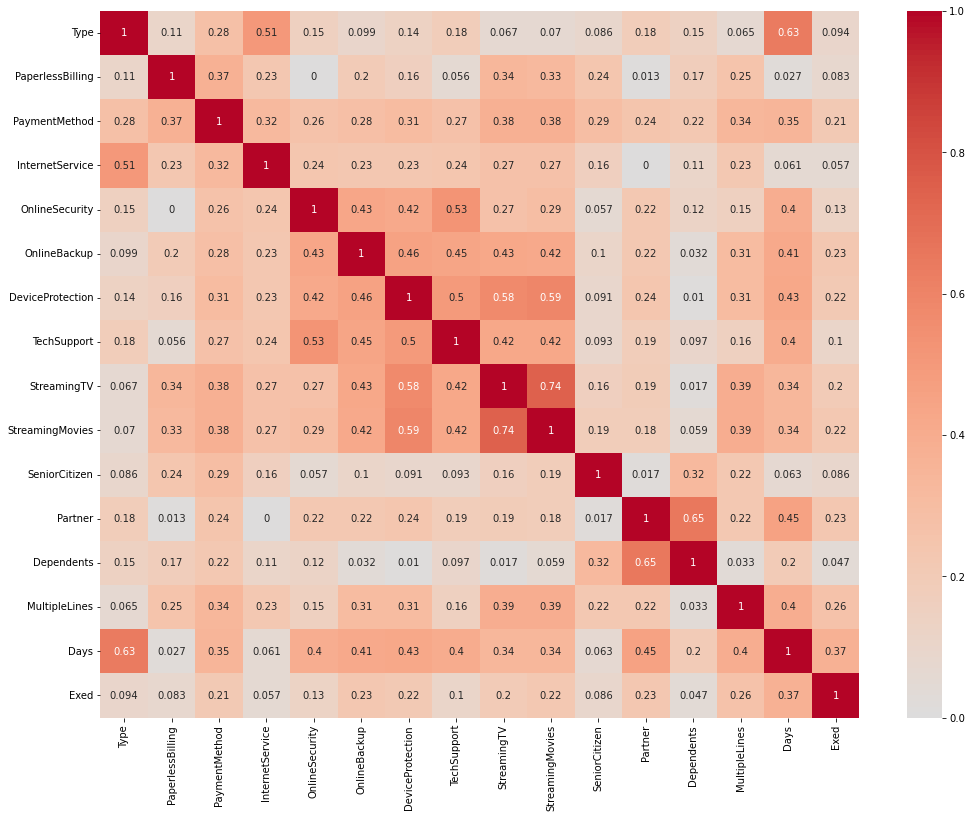

In [81]:
plt.figure(figsize=(17, 13))
sns.heatmap(data.phik_matrix(interval_cols=['Days']), center=0, cmap='coolwarm', annot=True);

In [82]:
target = data['Exed']
features = data.drop('Exed', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=220523, shuffle=True)


features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)
print(features_train.info(), features_test.info())

(5282, 19)
(5282,)
(1761, 19)
(1761,)
<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2205-LPVGL to 5375-XLDOF
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   SeniorCitizen                          5282 non-null   int64
 1   Days                                   5282 non-null   int64
 2   Type_One year                          5282 non-null   uint8
 3   Type_Two year                          5282 non-null   uint8
 4   PaperlessBilling_Yes                   5282 non-null   uint8
 5   PaymentMethod_Credit card (automatic)  5282 non-null   uint8
 6   PaymentMethod_Electronic check         5282 non-null   uint8
 7   PaymentMethod_Mailed check             5282 non-null   uint8
 8   InternetService_Fiber optic            5282 non-null   uint8
 9   InternetService_No                     5282 non-null   uint8
 10  OnlineSecurity_Yes                     5282 non-

In [83]:
if list(features_train.columns)!=list(features_test.columns):
    text = "Признаки не совпадают"
elif list(features_train.columns)==list(features_test.columns):
     text = "Признаки совпадают"

        
print(text)

Признаки совпадают


Масштабируем количественные признаки.

In [84]:
numeric = ['Days']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

display(features_train.head())

,SeniorCitizen,Days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Partner_Yes,Dependents_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,
2205-LPVGL,1,1.251417,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,1,1
5940-NFXKV,0,-1.197416,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1
5453-YBTWV,0,1.785043,0,1,1,1,0,0,1,0,1,1,1,1,1,0,1,1,0
1325-USMEC,0,1.785043,0,1,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1
3199-NPKCN,0,1.652002,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1


## Обучение моделей

**LogisticRegression**

In [85]:
%%time

lr = LogisticRegression(solver ='liblinear', random_state=RANDOM_STATE)


params = {'C': [0.1, 1, 10]}
    
                                   
lr_grid_search_cv = GridSearchCV(estimator=lr, param_grid=params, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
lr_grid_search_cv.fit(features_train, target_train)


lr_best_hyperparams = lr_grid_search_cv.best_params_
lr_best_score = lr_grid_search_cv.best_score_


print('Лучшие параметры модели', lr_best_hyperparams)
print('Лучшие метрика AUC-ROC модели', lr_best_score)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшие параметры модели {'C': 10}
Лучшие метрика AUC-ROC модели 0.7453378800219796
CPU times: total: 125 ms
Wall time: 346 ms


**RandomForestClassifier**

In [86]:
%%time

RFC = RandomForestClassifier(random_state=RANDOM_STATE)

params = {'n_estimators': range(1, 102, 10),
    'max_depth': [None] + [i for i in range(2, 7)]}


rfc_grid_search_cv = GridSearchCV(RFC, param_grid = params, verbose=1, scoring='roc_auc', cv=5, n_jobs=-1)
rfc_grid_search_cv.fit(features_train, target_train)
rfc_best_hyperparams = rfc_grid_search_cv.best_params_
rfc_best_score = rfc_grid_search_cv.best_score_
print('Лучшие параметры модели', rfc_best_hyperparams)
print('Лучшие метрика AUC-ROC модели', rfc_best_score)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
Лучшие параметры модели {'max_depth': 6, 'n_estimators': 101}
Лучшие метрика AUC-ROC модели 0.8155406493637833
CPU times: total: 2.06 s
Wall time: 7.02 s


**DecisionTreeClassifier**

In [87]:
%%time
DTC = DecisionTreeClassifier(random_state=RANDOM_STATE)

params = {'max_depth':  [None] + [i for i in range(2, 7)]}


dtc_grid_search_cv = GridSearchCV(DTC, param_grid = params, verbose=1, scoring='roc_auc', cv=5, n_jobs=-1)
dtc_grid_search_cv.fit(features_train, target_train)
dtc_best_hyperparams = dtc_grid_search_cv.best_params_
dtc_best_score = dtc_grid_search_cv.best_score_
print('Лучшие параметры модели', dtc_best_hyperparams)
print('Лучшие метрика AUC-ROC модели', dtc_best_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры модели {'max_depth': 5}
Лучшие метрика AUC-ROC модели 0.7799876403911308
CPU times: total: 219 ms
Wall time: 199 ms


**CatBoostClassifier**

In [88]:
%%time



catboost = CatBoostClassifier(random_state=RANDOM_STATE, loss_function='Logloss')

params = {
    'depth' : [None] + [i for i in range(2, 8, 2)], 
    'learning_rate' : [0.1, 0.01],
    'n_estimators': [100, 300, 600, 900]
}


catboost_grid_search_cv = GridSearchCV(catboost, param_grid = params, verbose=100, scoring='roc_auc', cv=5, n_jobs=-1)
catboost_grid_search_cv.fit(features_train, target_train)
catboost_best_hyperparams = catboost_grid_search_cv.best_params_
catboost_best_score = catboost_grid_search_cv.best_score_
print('Лучшие параметры модели', catboost_best_hyperparams)
print('Лучшие метрика AUC-ROC модели', catboost_best_score)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
0:	learn: 0.6216732	total: 143ms	remaining: 2m 8s
1:	learn: 0.5645614	total: 147ms	remaining: 1m 5s
2:	learn: 0.5219664	total: 149ms	remaining: 44.6s
3:	learn: 0.4896464	total: 152ms	remaining: 34s
4:	learn: 0.4647065	total: 155ms	remaining: 27.7s
5:	learn: 0.4452020	total: 157ms	remaining: 23.4s
6:	learn: 0.4302494	total: 159ms	remaining: 20.3s
7:	learn: 0.4152427	total: 162ms	remaining: 18s
8:	learn: 0.4059047	total: 164ms	remaining: 16.2s
9:	learn: 0.3942175	total: 166ms	remaining: 14.8s
10:	learn: 0.3843661	total: 168ms	remaining: 13.6s
11:	learn: 0.3767616	total: 171ms	remaining: 12.6s
12:	learn: 0.3706677	total: 173ms	remaining: 11.8s
13:	learn: 0.3671790	total: 175ms	remaining: 11.1s
14:	learn: 0.3637912	total: 178ms	remaining: 10.5s
15:	learn: 0.3597739	total: 180ms	remaining: 9.95s
16:	learn: 0.3567432	total: 182ms	remaining: 9.47s
17:	learn: 0.3536485	total: 185ms	remaining: 9.06s
18:	learn: 0.3501093	total: 188ms	

**LGBMClassifier**

In [89]:
%%time


lgbm = LGBMClassifier(random_state=RANDOM_STATE)

params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300, 600], 
    'max_depth': [4, 6, 10], 
    'colsample_bytree': [0.7, 0.9],
    'subsample': [0.7, 0.9]
             }


lgbm_grid_search_cv = GridSearchCV(lgbm, param_grid = params, verbose=100, scoring='roc_auc', cv=5, n_jobs=-1)
lgbm_grid_search_cv.fit(features_train, target_train)
lgbm_best_hyperparams = lgbm_grid_search_cv.best_params_
lgbm_best_score = lgbm_grid_search_cv.best_score_
print('Лучшие параметры модели', lgbm_best_hyperparams)
print('Лучшие метрика AUC-ROC модели', lgbm_best_score)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры модели {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.7}
Лучшие метрика AUC-ROC модели 0.9034296582979163
CPU times: total: 5.17 s
Wall time: 15.9 s


In [90]:
model= pd.Series(['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'CatBoostClassifier', 'LGBMClassifier'])
AUC_ROC = pd.Series([ round(lr_best_score, 2),
                     round(rfc_best_score, 2),
                     round(dtc_best_score, 2),
                     round(catboost_best_score, 2), 
                     round(lgbm_best_score, 2)])

result = pd.DataFrame({'model':model, "AUC-ROC":AUC_ROC})
result

,model,AUC-ROC
0,LogisticRegression,0.75
1,RandomForestClassifier,0.82
2,DecisionTreeClassifier,0.78
3,CatBoostClassifier,0.93
4,LGBMClassifier,0.90


###  Вывод:
- из объединенного полного датасета были выделены признаки и колонка таргета, разбиты на тренировочную 75% и тестовую 25% выборки 
- категориальные признаки были закодированы методом get_dummies(), численные были масштабированы
- для обучения использованы модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier, LGBMClassifier
- подбор лучших параметров для моделей был произведен с помощью GridSearchCV, кросс-валидация 5 раз
- лучший результат AUC-ROC 	0.92 имеет модель  CatBoostClassifier


##  Проверка лучшей модели на тесте

Поскольку модель уже обучена, то просто вынем лучшую обученую модель из GridSearchCV.

In [91]:
print('AUC-ROC на тестовой выборке:', round(roc_auc_score(target_test,
                                                          catboost_grid_search_cv.best_estimator_.predict_proba(features_test)[:, 1]), 2))

AUC-ROC на тестовой выборке: 0.95


**AUC-ROC на тестовой выборке: 0.95, минимальный порог от заказчика достигнут**

Посмотрим матрицу ошибок.

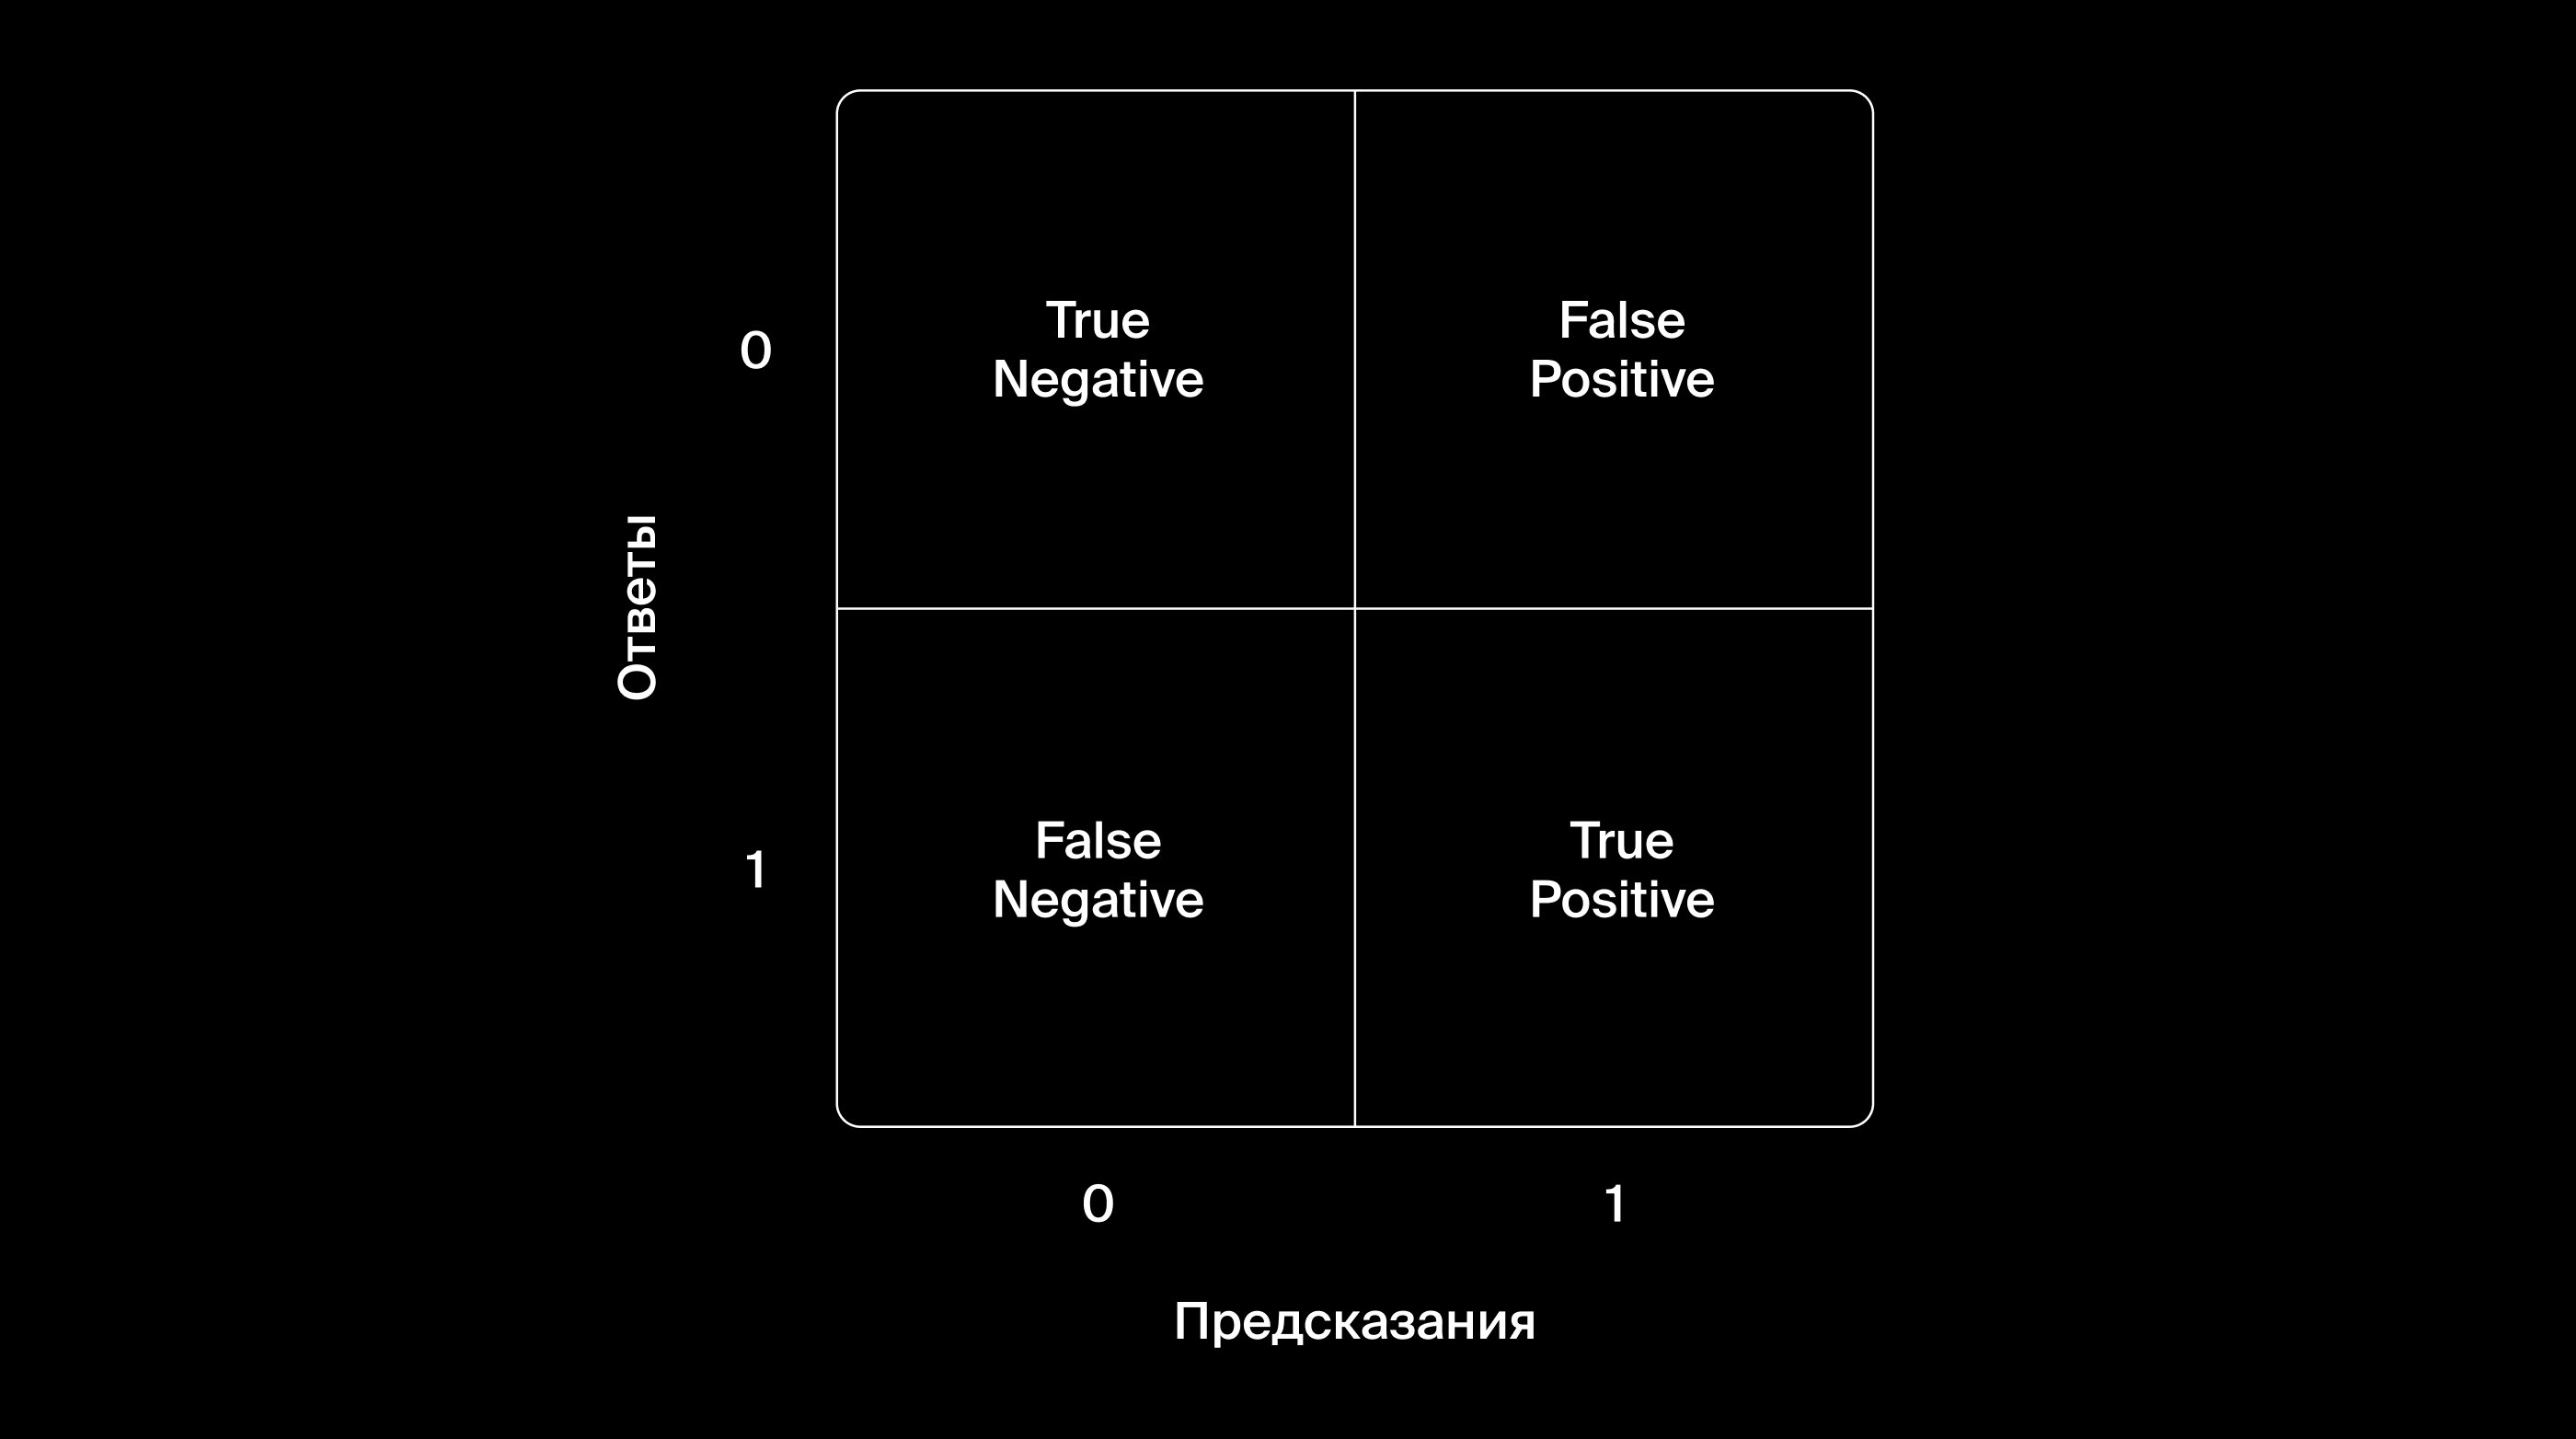

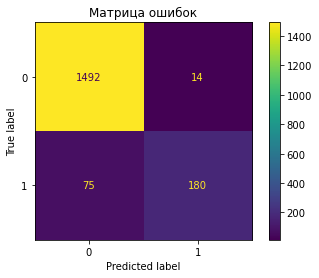

In [92]:
matrix = confusion_matrix(target_test, catboost_grid_search_cv.best_estimator_.predict(features_test))

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.title('Матрица ошибок')
plt.show()

In [93]:
print(matrix)

[[1492   14]
 [  75  180]]


1492 предсказаний истинно отрицательные (True Negative, TN), клиент остался<br>
180 предсказаний истинно положительные (True Positive, TP), клиент ушел <br>


14 предсказаний ложноположительные (False Positive, FP), модель ложно определила, что клиент остался <br>
75 предсказаний ложноотрицательные (False Negative, FN), модель ложно определила, что клиент ушел

In [94]:
best_model = catboost_grid_search_cv.best_estimator_

In [95]:
predicted_test = best_model.predict(features_test)
accuracy_test = accuracy_score(target_test, predicted_test)

print("Значение Accuracy (верное предсказание):", round(accuracy_test, 2), '%')

Значение Accuracy (верное предсказание): 0.95 %


Поскольку мы не устраняли баланс классов, то посмотрим дополнительные метрики recall, precision, F1-мера

In [96]:
# Полнота

print('Полнота:', round(recall_score(target_test, best_model.predict(features_test)), 3))

# Точность

print('Точность:', round(precision_score(target_test, best_model.predict(features_test)), 2))

# F1-мера

print('F1-мера:', round(f1_score(target_test, best_model.predict(features_test)), 2))

Полнота: 0.706
Точность: 0.93
F1-мера: 0.8


Построим график ROC-кривой.

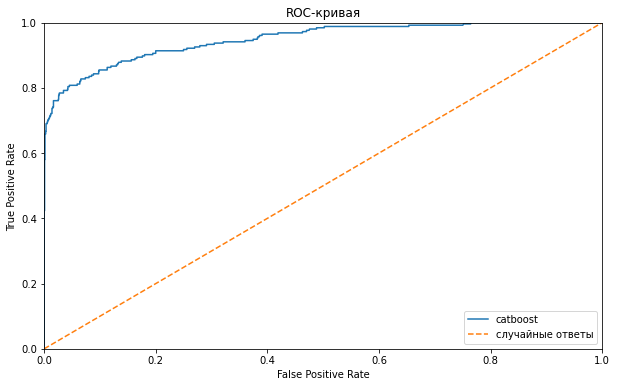

In [97]:
fpr, tpr, thresholds = roc_curve(target_test, best_model.predict_proba(features_test)[:, 1])# < напишите код здесь >

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='catboost')
plt.plot([0, 1], [0, 1], linestyle='--', label='случайные ответы')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Посмотрим градацию значимости признаков.

In [98]:
best_feature = best_model.get_feature_importance()
best_feature

array([ 0.55052571, 69.68963155,  2.41084389,  3.84270584,  1.06360389,
        1.04065373,  0.96409085,  1.95231781,  1.64956541,  0.70730196,
        1.18203804,  1.55669594,  1.3631965 ,  0.98456385,  1.37492352,
        2.1082115 ,  3.15689854,  1.30167146,  3.10056001])

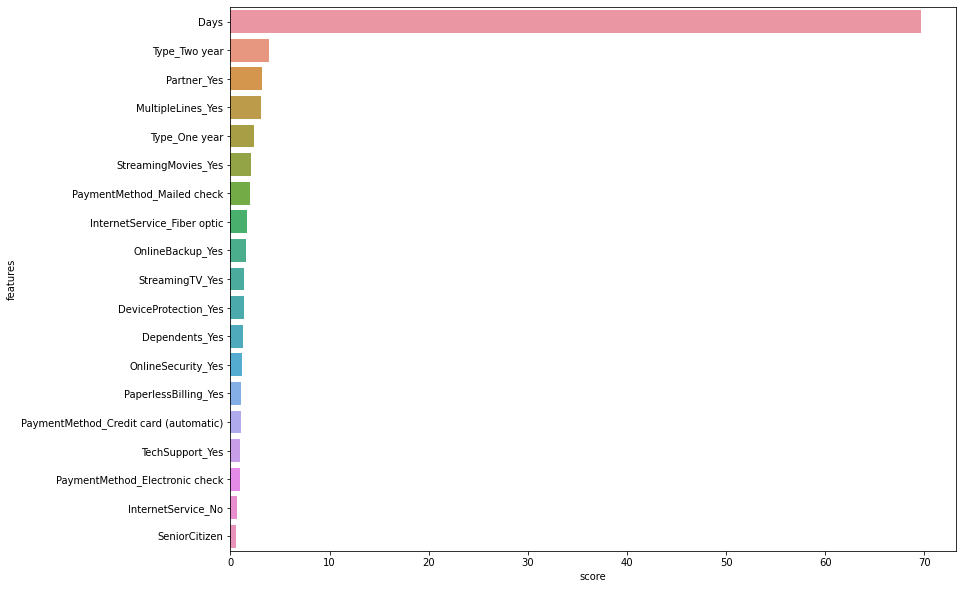

In [99]:
best_model_features_data = pd.DataFrame({'features': best_model.feature_names_, 'score': best_model.get_feature_importance()})
best_model_features_data = best_model_features_data.sort_values(by="score", ascending = False)



plt.figure(figsize=(13, 10))
sns.barplot(x=best_model_features_data["score"], y=best_model_features_data["features"]);

Самым важным оказался признак срок обслуживания клиента, он же имел большее количество сильных корреляций с другими признаками.

###  Вывод:
AUC-ROC на тестовой выборке: 0.95, минимальный порог от заказчика 0.85 достигнут. <br>
Матрица ошибок 
      
      [1492   14]
      [  75  180]
     
Значение Accuracy (верное предсказание): 0.95 %

Построили график распределения ROC-кривой.

Большую важность из признаков имеет срок обслуживания клиента

## Отчет

Главная задача проекта: создать модель для предсказания оттока клиентов. Метрика на тестовой выборке AUC-ROC=>0.85
Основные этапы в работе:
* были получены 4 датасета:<br>
contract_new.csv — информация о договоре;<br>
personal_new.csv — персональные данные клиента;<br>
internet_new.csv — информация об интернет-услугах;<br>
phone_new.csv — информация об услугах телефонии
    
    
* изучил данные, объединил 4 таблицы в одну. Проверил отсутствие дубликатов, заполнил пропуски, изменил типы данных. Добавил колонку с количеством дней обслуживания клиента, добавил целевой признак. Имеется дисбаланс классов в сторону клиент продолжает обслуживаться. 


* провел анализ данных. Большее количество клиентов в находятся в районе оплаты 20 у.е., они же и остаются. Уходят те кто платит больше остальных помесячно. Уходят те кто заплатил за все время обслуживания до 2000, эта же и самая многочисленная группа клиентов. Если клиент обслуживается более 2000 дней то расторжение контракта сводится к минимуму, эта же группа на втором месте по многочисленности, на первом 250-1500 дней. Меньший отток среди пенсионеров и тех людей кто получают бумажные чеки.Большую корреляцию с со всеми признаками имеет месячная оплата что естесственно.


* подготовил данные для обучения моделей, разбил на обучающую 75% и тестовую 25% выборки, отобрал признаки


* категориальные признаки были закодированы методом get_dummies(), численные были масштабированы
* для обучения использованы модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier, LGBMClassifier
* подбор лучших параметров для моделей был произведен с помощью GridSearchCV, кросс-валидация с 5 фолдами.
* лучший результат AUC-ROC 0.93 при кросс-валидации на обучающей выборке имеет модель CatBoostClassifier
"

    
    model	              AUC-ROC
    LogisticRegression   	 0.75
	RandomForestClassifier	0.82
	DecisionTreeClassifier	0.78
	CatBoostClassifier	    0.93
	LGBMClassifier	        0.90



* Лучшие параметры модели CatBoostClassifier {'depth': 2, 'learning_rate': 0.1, 'n_estimators': 900}

**При проверке на тестовой выборке лучшей моделью CatBoostClassifier, была достигнута метрика AUC-ROC = 0.95.**<br>
**Матрица ошибок**


      [1492   14]
      [  75  180]
 
Модель верно определила:
- 1492 предсказаний истинно отрицательные (True Negative, TN), клиент остался<br>
- 180 предсказаний истинно положительные (True Positive, TP), клиент ушел <br>

Модель ошиблась:
* 14 предсказаний ложноположительные (False Positive, FP), модель ложно определила, что клиент остался <br>
* 75 предсказаний ложноотрицательные (False Negative, FN), модель ложно определила, что клиент ушел 

**Значение Accuracy (верное предсказание): 0.95 %**

Список использованных закодированных признаков:



    
    TotalCharges - сумма всего поступлений от клиента
    SeniorCitizen - пенсионер
    Days - количество дней обслуживания
    Type_One year - тип оплаты один раз в год
    Type_Two year - тип оплаты один раз в 2 года
    PaperlessBilling_Yes - электронный платёжный документ
    PaymentMethod_Credit card (automatic) -  метод оплаты кредитной картой
    PaymentMethod_Electronic check - метод опллаты электронный чек
    PaymentMethod_Mailed check - метод оплаты чек по почте
    InternetService_Fiber optic - подключен оптоволоконный интернет
    InternetService_No - не подключен интернет
    OnlineSecurity_Yes - подключена защита в интернете
    OnlineBackup_Yes - подключено облачное хранилище
    DeviceProtection_Yes - подключена защита устройств
    TechSupport_Yes - подключена услуга технической поддержки
    StreamingTV_Yes - подключено потоковое телевидение
    StreamingMovies_Yes - подключено потоковое кино
    Partner_Yes - клиент находится в паре/браке
    Dependents_Yes - наличие иждивенцев
    MultipleLines_Yes - наличие возможности ведения параллельных линий во время звонка
     
Важнейшим из данных признаков является срок обслуживания клиента.

Работа над проектом велась без отклонений от плана. Основные сложности при выполнении проекта были связаны с малым опытом, проблемы решались путём изучения информации из открытых источников и документации по применяемым инструментам.